### 🎥 Cine-Match - Movie Recommendation System 📹


### File: Content_Based_Filtering.ipynb - CineMatch

- Contributor: Sudesh Kumar Santhosh Kumar
- Email: santhosh@usc.edu
- GitHub: [Sudesh Kumar](https://github.com/SudeshKumarSanthosh)
- Date: 5th December, 2023
- Course: EE-541 Introduction to Deep Learning
- Team:
  - Sudesh Kumar Santhosh Kumar
  - Ori Shirin

### Description:

This notebook, Content_Based_Filtering.ipynb, is dedicated to the development of the CineMatch recommender system's content-based filtering component. The journey begins with the importation of our meticulously curated dataset, which is an amalgamation of credits and movie metadata, refined and transformed through previous stages of exploratory data analysis and preprocessing.

Within these digital pages, we delve into a myriad of sophisticated techniques designed to enhance the art of recommendation. By harnessing the dual forces of weighted scores and popularity metrics, we aim to distill a distilled essence of cinematic appeal, balancing the scales between audience adoration and critical acclaim.

Moving beyond the realm of numerical heuristics, we employ the power of cosine similarity to unearth the subtle connections woven throughout the tapestry of movie genres, plot descriptions.


## Part 1 - Installation and Dataset Loading

---


### S1. Setting up the notebook


### Uncomment the following lines to run the script in Google Colab.

In [70]:
# !pip install transformers

In [71]:
# !pip install sentence_transformers

In [72]:
# !pip install torch scikit-learn

### 1.1. Importing all necessary packages


In [73]:
import os
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image


from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Uncomment while using Google Colab to mount your drive to this notebook.
# from google.colab import drive
# drive.mount('/content/drive')

### 1.2. Defining Directories and Helper Functions


In [74]:
# Data Directory
data_dir = "../Input/Data/"
cleansed_data_dir = "../Input/CleansedData/"
embeddings_dir = "../Input/Embeddings/"


# Data Directory - When using google colaboratory.
# drive/My Drive/ColabDrive/MovieData/movies_metadata.csv
""" 
data_dir = "drive/MyDrive/CineMatch/Input/Data/"
cleansed_data_dir = "drive/MyDrive/CineMatch/Input/CleansedData/"
embeddings_dir = "drive/MyDrive/CineMatch/Input/Embeddings" 

"""

if not os.path.exists(embeddings_dir):
  os.makedirs(embeddings_dir)

if not os.path.exists(data_dir):
  os.makedirs(data_dir)

if not os.path.exists(cleansed_data_dir):
  os.makedirs(cleansed_data_dir)

if torch.cuda.is_available():
    device = torch.device(("cuda"))
    print("{:^80}".format(f"There are {torch.cuda.device_count()} available GPU's"))
    print("{:^80}".format(f"We will use the GPU: {torch.cuda.get_device_name(0)}"))

else:
    print("{:^80}".format("No GPU available, using the CPU!"))
    device = torch.device("cpu")

model_name='bert-base-uncased'
# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained(model_name)


                        No GPU available, using the CPU!                        


In [75]:
def load_dataset(directory, filename):
    """
    Loads a dataset from a CSV file into a Pandas DataFrame.

    Parameters:
    - file_path (str): The complete file path of the CSV file to be loaded.

    Returns:
    - pandas.DataFrame: A DataFrame containing the data from the CSV file.

    This function will read the CSV file located at 'file_path' and return it as a DataFrame.
    It assumes that the first row of the CSV file contains the headers.
    """
    try:
        file_path = os.path.join(directory, filename)
        # Loading the dataset
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully from {file_path}")
        return df
    except Exception as e:
        print(f"An error occurred while loading the dataset: {e}")
        return None


def analyze_dataframe(df):
    # Identifying categorical and numerical features
    categorical_features = [col for col in df.columns if df[col].dtype == "object"]
    numerical_features = [col for col in df.columns if df[col].dtype == "float64"]

    # Printing general information about the DataFrame
    print(f"Shape of the Data: {df.shape}")
    print(f"Total number of Data-Points in the Data, N: {df.shape[0]}")
    print(f"Total number of dimensions in the Data, D: {df.shape[1]}")
    print()

    # Printing details about features
    print(f"Categorical Features: {categorical_features}")
    print(f"Numerical Features: {numerical_features}")
    print(f"Total number of Categorical Features: {len(categorical_features)}")
    print(f"Total number of Numerical Features: {len(numerical_features)}")


def save_dataframe(df, directory, filename="preprocessed_data.csv"):
    """
    Saves the given DataFrame to a CSV file in the specified directory.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to be saved.
    - directory (str): Path of the directory where the CSV file will be saved.
    - filename (str, optional): Name of the CSV file. Defaults to 'preprocessed_data.csv'.

    The function will create the directory if it does not exist. The DataFrame is saved
    without the index.
    """
    # Constructing the full file path
    file_path = os.path.join(directory, filename)

    # Creating the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Saving the DataFrame as a CSV file
    df.to_csv(file_path, index=False)
    print(f"DataFrame saved successfully to {file_path}")

### 1.3 Loading the Cleaned dataset into the notebook


In [76]:
df = load_dataset(cleansed_data_dir, "Movies.csv")

Dataset loaded successfully from ../Input/CleansedData/Movies.csv


In [77]:
missing_values = df.isnull().sum()
print(missing_values)

adult                   0
budget                  0
genres                  0
id                      0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
vote_average            0
vote_count              0
keywords                0
crew                    0
characters              0
actors                  0
dtype: int64


### 1.4. Overview of the Loaded Dataset


In [78]:
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000.0,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,English,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,1995-12-15,262797249.0,104.0,"English, Français",6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,1995-12-22,0.0,101.0,English,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000.0,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,English,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0.0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,1995-02-10,76578911.0,106.0,English,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42363 non-null  bool   
 1   budget                42363 non-null  float64
 2   genres                42363 non-null  object 
 3   id                    42363 non-null  int64  
 4   original_language     42363 non-null  object 
 5   original_title        42363 non-null  object 
 6   overview              42363 non-null  object 
 7   popularity            42363 non-null  float64
 8   production_companies  42363 non-null  object 
 9   production_countries  42363 non-null  object 
 10  release_date          42363 non-null  object 
 11  revenue               42363 non-null  float64
 12  runtime               42363 non-null  float64
 13  spoken_languages      42363 non-null  object 
 14  vote_average          42363 non-null  float64
 15  vote_count         

In [80]:
analyze_dataframe(df)

Shape of the Data: (42363, 20)
Total number of Data-Points in the Data, N: 42363
Total number of dimensions in the Data, D: 20

Categorical Features: ['genres', 'original_language', 'original_title', 'overview', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'keywords', 'crew', 'characters', 'actors']
Numerical Features: ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
Total number of Categorical Features: 12
Total number of Numerical Features: 6


## Part 2 - Feature Engineering

---


### 2.1. Generating weighted rating as a new feature


We will compute a weighted_score / weighted_rating which is calculated from the numerical features like `vote_count` and `vote_average`. This is computed as follows:


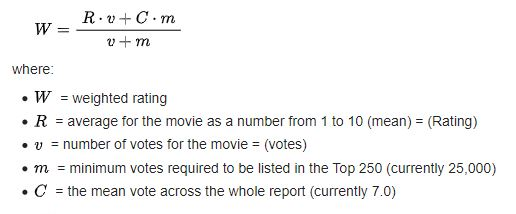

In [81]:
Image(filename="../Input/weighted.jpg")

In [82]:
R = df["vote_average"]
v = df["vote_count"]

# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df["vote_count"].quantile(0.8)
C = df["vote_average"].mean()

df["weighted_average"] = (R * v + C * m) / (v + m)

In [83]:
df.head(3)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,weighted_average
0,False,30000000.0,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",7.680916
1,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",6.874224
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",6.198525


In [84]:
analyze_dataframe(df)

Shape of the Data: (42363, 21)
Total number of Data-Points in the Data, N: 42363
Total number of dimensions in the Data, D: 21

Categorical Features: ['genres', 'original_language', 'original_title', 'overview', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'keywords', 'crew', 'characters', 'actors']
Numerical Features: ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'weighted_average']
Total number of Categorical Features: 12
Total number of Numerical Features: 7


### 2.2. Standardizing Popularity and Weighted Average


In [85]:
scaler = MinMaxScaler()

# Scale the 'popularity' and 'weighted_average' columns
scaled_columns = scaler.fit_transform(df[["popularity", "weighted_average"]])

# Create new columns in df for the scaled values
df["scaled_popularity"] = scaled_columns[:, 0]
df["scaled_weighted_average"] = scaled_columns[:, 1]


weighted_df = pd.DataFrame(scaled_columns, columns=["popularity", "weighted_average"])

weighted_df.index = df["original_title"]

In [86]:
weighted_df.info()
weighted_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 42363 entries, Toy Story to Queerama
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        42363 non-null  float64
 1   weighted_average  42363 non-null  float64
dtypes: float64(2)
memory usage: 992.9+ KB


,popularity,weighted_average
original_title,,
Toy Story,0.040087,0.811146
Jumanji,0.031079,0.681191
Grumpier Old Men,0.021394,0.572338
Waiting to Exhale,0.007049,0.513422
Father of the Bride Part II,0.015320,0.490365


### 2.3. Generation of a Popularity Based Score


- People watch a movie not just because they see a good rating for that movie, but also because of the `hype of certain movie.` So, in this case, put popularity into a consideration is a wise choice.

- Let's take `40% weight for weighted average` and `60% weight for popularity` considering people don't want to miss a hype movie even the reviews and ratings are poor.

- Now, we create a new column (feature) called `score`.


In [87]:
df["score"] = (
    df["scaled_weighted_average"] * 0.4
    + df["scaled_popularity"].astype("float64") * 0.6
)
weighted_df["score"] = (
    weighted_df["weighted_average"] * 0.4
    + weighted_df["popularity"].astype("float64") * 0.6
)

In [88]:
weighted_df_sorted = weighted_df.sort_values(by="score", ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603514,0.841405
Big Hero 6,0.390602,0.827550,0.565381
Baby Driver,0.416507,0.727723,0.540993
Guardians of the Galaxy Vol. 2,0.338511,0.794855,0.521049
Pulp Fiction,0.257449,0.908387,0.517824
Deadpool,0.343132,0.764644,0.511737
Gone Girl,0.282748,0.843403,0.507010
The Dark Knight,0.224968,0.909115,0.498627
Avatar,0.338036,0.732629,0.495873


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   adult                    42363 non-null  bool   
 1   budget                   42363 non-null  float64
 2   genres                   42363 non-null  object 
 3   id                       42363 non-null  int64  
 4   original_language        42363 non-null  object 
 5   original_title           42363 non-null  object 
 6   overview                 42363 non-null  object 
 7   popularity               42363 non-null  float64
 8   production_companies     42363 non-null  object 
 9   production_countries     42363 non-null  object 
 10  release_date             42363 non-null  object 
 11  revenue                  42363 non-null  float64
 12  runtime                  42363 non-null  float64
 13  spoken_languages         42363 non-null  object 
 14  vote_average          

### 2.4. Saving the Feature Engineered Dataset


In [90]:
# save_dataframe(df, cleansed_data_dir, "Movies_Weighted_Score.csv")

## Part 4 - BERT Embeddings Generation

---


### 4.1. Defining Helper Functions for EMbeddings generation

### 4.1.1. Helper Function to Analyze the Text Length Distribution

In [91]:
def analyze_text_length(texts):
    """
    Analyzes the length of texts in terms of tokens from the specified transformer model.

    Args:
    texts (pd.Series): A pandas Series containing text data.
    model_name (str): Name of the transformer model to use for tokenization.

    Returns:
    dict: A dictionary containing statistics about text lengths.
    """
    
    # Tokenize all texts and record their lengths
    input_ids = []
    lengths = []
    for text in texts:
        encoded_text = tokenizer.encode(text, add_special_tokens=True)
        input_ids.append(encoded_text)
        lengths.append(len(encoded_text))

    # Analyzing the distribution of sentence lengths
    max_index, max_value = max(enumerate(lengths), key=lambda pair: pair[1])
    min_length = min(lengths)
    max_length = max_value
    median_length = np.median(lengths)

    

    num_over = 0

    # For all of the length values...
    for length in lengths:
        # Tally if it's over 512.
        if length > 512:
            num_over += 1
    
    # Compile statistics
    stats = {
        "total_texts": len(texts),
        "min_length": min_length,
        "max_length": max_length,
        "median_length": median_length,
        "num_exceeding_512": num_over,
        "percentage_exceeding_512": (num_over / len(texts)) * 100
    }

    return stats

### 4.1.2 Helper Function to Combine Textual Features Together

In [92]:
def combine_features(row, max_token_limit=500):
    """
    Combine selected features into a single text string for BERT embeddings.

    Args:
    row (pd.Series): A row of the DataFrame.
    max_token_limit (int): Maximum allowed token limit before truncation.
    tokenizer: Tokenizer object from the BERT model (required for token count checks).

    Returns:
    str: Combined text from selected features.
    """
    combined_text = row['overview']

    # Split the comma-separated strings into lists
    genres = row['genres'].split(', ') if isinstance(row['genres'], str) else []
    keywords = row['keywords'].split(', ') if isinstance(row['keywords'], str) else []
    crew = row['crew'].split(', ') if isinstance(row['crew'], str) else []
    actors = row['actors'].split(', ') if isinstance(row['actors'], str) else []
    production_companies = row['production_companies'].split(', ') if isinstance(row['production_companies'], str) else []

    # Add genres, keywords, adult, language, and production companies to the combined text
    combined_text += ' Genre: ' + ', '.join(genres)
    combined_text += ' Keywords: ' + ', '.join(keywords)
    combined_text += ' Adult: ' + str(row['adult'])
    combined_text += ' Language: ' + str(row['spoken_languages'])
    combined_text += ' Production Companies: ' + ', '.join(production_companies)

    # Conditional inclusion of 'crew' and 'actors'
    if tokenizer and len(tokenizer.tokenize(combined_text)) < max_token_limit:
        # Include key crew members and lead actors, limit their number to control token size
        combined_text += ' Crew: ' + ', '.join(crew[:1])  # Including only the first crew member
        combined_text += ' Actors: ' + ', '.join(actors[:2])  # Including top 2 actors

        # Truncate if exceeds max token limit
        if len(tokenizer.tokenize(combined_text)) > max_token_limit:
            tokens = tokenizer.tokenize(combined_text)[:max_token_limit]
            combined_text = tokenizer.convert_tokens_to_string(tokens)

    return combined_text


### 4.1.3 Helper Functions to Generate and Load Embeddings


In [93]:
def generate_embeddings(corpus, lang_model, file_name, embeddings_dir, batch_size=32, max_seq_len=128):
    '''
    Generate embeddings for the given corpus using a specified language model.

    Parameters:
        corpus (list): List of sentences to be embedded.
        lang_model (str): Language model name or path to the pre-trained model.
        file_name (str): Name of the file to save the generated embeddings.
        max_seq_len (int): Maximum sequence length for the embeddings (default: 128).
    '''

    # Define the file path to save the generated embeddings
    embeddings_file_path = f"{embeddings_dir}/{file_name}.npz"

    # Create an instance of the SentenceTransformer
    embedder = SentenceTransformer(lang_model, device=device)

    # Update the max_seq_length if necessary
    if max_seq_len != 128:
        embedder.max_seq_length = max_seq_len

    # Generate embeddings
    corpus_embeddings = embedder.encode(corpus, batch_size=batch_size, show_progress_bar=True,
                                        normalize_embeddings=True, convert_to_numpy=True)

    # Save the embeddings
    with open(embeddings_file_path, "wb") as emb_file:
      np.save(emb_file, corpus_embeddings)
      
    print(f"Embeddings saved to {embeddings_file_path}")

In [94]:
def load_embeddings(directory, filename):
    '''
    Load BERT embeddings from a file.

    Parameters:
        input_file_path (str): File path from which the embeddings will be loaded.
    
    Returns:
        numpy.ndarray: Array containing the loaded embeddings.
    '''
    input_file_path = os.path.join(directory, filename)
    corpus_embeddings = np.load(input_file_path)
    return list(corpus_embeddings)

### 4.2. Combining Textual features

In [95]:
df['combined_text'] = df.apply(combine_features, axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


In [96]:
df["combined_text"][67]

'Craig and Smokey are two guys in Los Angeles hanging out on their porch on a Friday afternoon, smoking and drinking, looking for something to do. Genre: Comedy Keywords: rap music, parent child relationship, rapper, job Adult: False Language: English Production Companies: New Line Cinema Crew: F. Gary Gray Actors: Ice Cube, Chris Tucker'

In [97]:
stats = analyze_text_length(df["combined_text"])


In [98]:
stats

{'total_texts': 42363,
 'min_length': 27,
 'max_length': 671,
 'median_length': 115.0,
 'num_exceeding_512': 5,
 'percentage_exceeding_512': 0.011802752401860114}

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   adult                    42363 non-null  bool   
 1   budget                   42363 non-null  float64
 2   genres                   42363 non-null  object 
 3   id                       42363 non-null  int64  
 4   original_language        42363 non-null  object 
 5   original_title           42363 non-null  object 
 6   overview                 42363 non-null  object 
 7   popularity               42363 non-null  float64
 8   production_companies     42363 non-null  object 
 9   production_countries     42363 non-null  object 
 10  release_date             42363 non-null  object 
 11  revenue                  42363 non-null  float64
 12  runtime                  42363 non-null  float64
 13  spoken_languages         42363 non-null  object 
 14  vote_average          

### 4.3. Saving the new Data Framw with combined_text

In [100]:
df.drop(['scaled_weighted_average', 'scaled_popularity', "weighted_average"], 
            axis='columns', inplace=True)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42363 non-null  bool   
 1   budget                42363 non-null  float64
 2   genres                42363 non-null  object 
 3   id                    42363 non-null  int64  
 4   original_language     42363 non-null  object 
 5   original_title        42363 non-null  object 
 6   overview              42363 non-null  object 
 7   popularity            42363 non-null  float64
 8   production_companies  42363 non-null  object 
 9   production_countries  42363 non-null  object 
 10  release_date          42363 non-null  object 
 11  revenue               42363 non-null  float64
 12  runtime               42363 non-null  float64
 13  spoken_languages      42363 non-null  object 
 14  vote_average          42363 non-null  float64
 15  vote_count         

In [102]:
save_dataframe(df, cleansed_data_dir, "Movied_Combined_Text.csv")

DataFrame saved successfully to ../Input/CleansedData/Movied_Combined_Text.csv


### 4.4. Generate BERT Embeddings using Sentence Transformers

The embeddings are generated in Google Colab and saved in the Embeddings Directory

In [103]:
""" generate_embeddings(list(df["combined_text"]), 
                    lang_model="all-roberta-large-v1",
                    file_name="Movies_Embeddings_Roberta",
                    embeddings_dir=embeddings_dir,
                    batch_size=64,
                    max_seq_len=512) """

' generate_embeddings(list(df["combined_text"]), \n                    lang_model="all-roberta-large-v1",\n                    file_name="Movies_Embeddings_Roberta",\n                    embeddings_dir=embeddings_dir,\n                    batch_size=64,\n                    max_seq_len=512) '

### 3.4. Loading the BERT Embeddings into the notebook

In [104]:
bert_embeddings = load_embeddings(embeddings_dir, "Movies_Embeddings_DistilRoberta.npz")
print(f"Length of a sample embeddings: {len(bert_embeddings[69])}")
df["embeddings"] = bert_embeddings

Length of a sample embeddings: 768


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42363 non-null  bool   
 1   budget                42363 non-null  float64
 2   genres                42363 non-null  object 
 3   id                    42363 non-null  int64  
 4   original_language     42363 non-null  object 
 5   original_title        42363 non-null  object 
 6   overview              42363 non-null  object 
 7   popularity            42363 non-null  float64
 8   production_companies  42363 non-null  object 
 9   production_countries  42363 non-null  object 
 10  release_date          42363 non-null  object 
 11  revenue               42363 non-null  float64
 12  runtime               42363 non-null  float64
 13  spoken_languages      42363 non-null  object 
 14  vote_average          42363 non-null  float64
 15  vote_count         

In [106]:
df.head(3)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,score,combined_text,embeddings
0,False,30000000.0,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,English,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",0.348510,"Led by Woody, Andy's toys live happily in his ...","[0.017651884, -0.0007875326, -0.009459613, -0...."
1,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,"English, Français",6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",0.291124,When siblings Judy and Peter discover an encha...,"[-0.019318212, -0.039893534, 0.04716879, 0.024..."
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,...,English,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",0.241771,A family wedding reignites the ancient feud be...,"[-0.007591387, -0.04258443, 0.0010542952, 0.01..."


In [107]:
df.shape

(42363, 23)

### 3.5. Combining Embeddings, Popularity_Score and Numerical features

### 3.5.1 Standardize Numerical Features to combine with Embeddings

In [108]:
numerical_features = df[['revenue', 'budget', 'runtime']]
scaled_numerical_features = scaler.fit_transform(numerical_features)


### 3.5.2 Convert Embeddings and scores to numpy arrays

In [109]:
embeddings_array = np.stack(df["embeddings"].to_numpy())

In [110]:
score_array = df["score"].to_numpy().reshape(-1, 1)

In [111]:
print(f"Shape of Embeddings: {embeddings_array.shape}")
print(f"Shape of Scaled Numerical Features: {scaled_numerical_features.shape}")
print(f"Shape of score array: {score_array.shape}") 

Shape of Embeddings: (42363, 768)
Shape of Scaled Numerical Features: (42363, 3)
Shape of score array: (42363, 1)


In [112]:
combined_features = np.hstack((embeddings_array, score_array, scaled_numerical_features))
combined_features.shape
type(combined_features)

numpy.ndarray

In [113]:
sorted_df = df.sort_values(by='score', ascending=False)

# Select the top 10000 entries based on the score
top_df = sorted_df.head(10000)

In [114]:
# Extract the embeddings for these top entries
top_embeddings = np.stack(top_df['embeddings'].to_numpy())

# If you also need the corresponding scaled numerical features for these top entries
# Make sure the index aligns with the top_df
top_scaled_numerical_features = scaled_numerical_features[top_df.index]

top_scores = top_df['score'].to_numpy().reshape(-1, 1)

# Combine top embeddings with the corresponding numerical features
top_combined_features = np.hstack((top_embeddings, top_scaled_numerical_features, top_scores))
print(top_combined_features.shape)

(10000, 772)


In [115]:
def batch_cosine_similarity(X, batch_size=100):
    cos_sim_matrix = np.zeros((X.shape[0], X.shape[0]))

    for start in range(0, X.shape[0], batch_size):
        end = min(start + batch_size, X.shape[0])
        batch_cos_sim = cosine_similarity(X[start:end], X)
        cos_sim_matrix[start:end] = batch_cos_sim

    return cos_sim_matrix